<a href="https://colab.research.google.com/github/andrebelem/ASTOC/blob/main/SNIPPET_4_%5Boriginal%5D_EOF_analysis_%5BMaterial_de_Refer%C3%AAncia%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Análise de Funções Ortogonais Empíricas (EOF) é uma técnica estatística utilizada para decompor a variabilidade espacial e temporal de conjuntos de dados multidimensionais, como dados climáticos ou oceânicos. Ela identifica padrões dominantes de variabilidade em séries temporais e campos espaciais, como padrões de circulação atmosférica e oscilações oceânicas. Amplamente aplicada em geociências e climatologia, a EOF ajuda a compreender e interpretar a estrutura das variáveis climáticas, contribuindo para previsões climáticas e estudos sobre mudanças climáticas. Embora possa ser usada em conjunto com técnicas de aprendizado de máquina, a EOF por si só é uma ferramenta estatística essencial para análise de dados climáticos.

Este material de referência é baseado nos pacotes `eofs`. Note que existe um vasto material teórico sobre o assunto.
O link para ambos (com exemplos) está aqui <br>
`EOFS` https://ajdawson.github.io/eofs/latest/userguide/index.html<br>

In [1]:
# antes de iniciar, vamos dar import em tudo que vamos precisar aqui
# os comandos abaixo instalam várias rotinas para você trabalhar com dados geoespaciais
# *** note que pode demorar um pouco para instalar tudo isso
# se você quiser ver o que ele está fazendo, só descomente abaixo o capture
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cartopy
!pip uninstall -y shapely    # cartopy e shapely não são amigos !)
!pip install shapely --no-binary shapely
!pip install geopandas

Antes de começarmos com o que interessa tem um pouco de blá-blá-blá para plotar. Notem que vamos usar dados de SST a partir do banco da NOAA (COBE)

In [2]:
!wget https://downloads.psl.noaa.gov/Datasets/COBE/sst.mon.mean.nc

--2024-02-29 10:11:09--  https://downloads.psl.noaa.gov/Datasets/COBE/sst.mon.mean.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.86
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164633412 (157M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.nc’

sst.mon.mean.nc     100%[===================>] 157.01M   114MB/s    in 1.4s    

2024-02-29 10:11:11 (114 MB/s) - ‘sst.mon.mean.nc’ saved [164633412/164633412]



In [3]:
import xarray as xr

dset_sst = xr.open_dataset('sst.mon.mean.nc')
# magic !! Rotacionando o globo
dset_sst = dset_sst.sst
dset_sst.coords['lon'] = (dset_sst.coords['lon'] + 180) % 360 - 180
dset_sst = dset_sst.sortby(dset_sst.lon)

dset_sst # vendo o que tem aqui dentro

<xarray.DataArray 'sst' (time: 1590, lat: 180, lon: 360)>
[103032000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2023-06-01
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    valid_range:   [-5. 40.]
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual obs
    actual_range:  [-1.7999996 34.87     ]

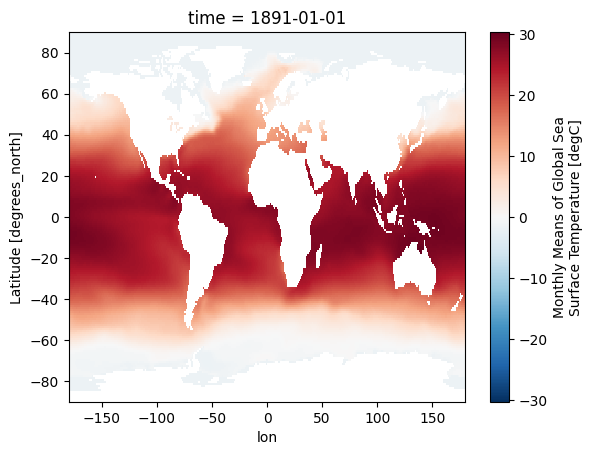

In [4]:
dset_sst.isel(time=0).plot()

Decidi fazer a EOF com o Atlântico inteiro...

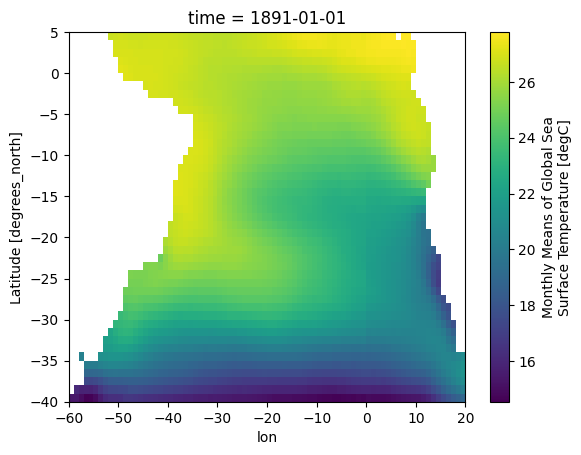

In [5]:
dset_SA = dset_sst.sel(lat=slice(5,-40),lon=slice(-60,20))
# olhando como ficou o corte
dset_SA.isel(time=0).plot()

In [6]:
# agora calculando a anomalia de temperatura (decidi usar a série toda ! cautela aqui)
dset_SA_anom = dset_SA - dset_SA.mean('time')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


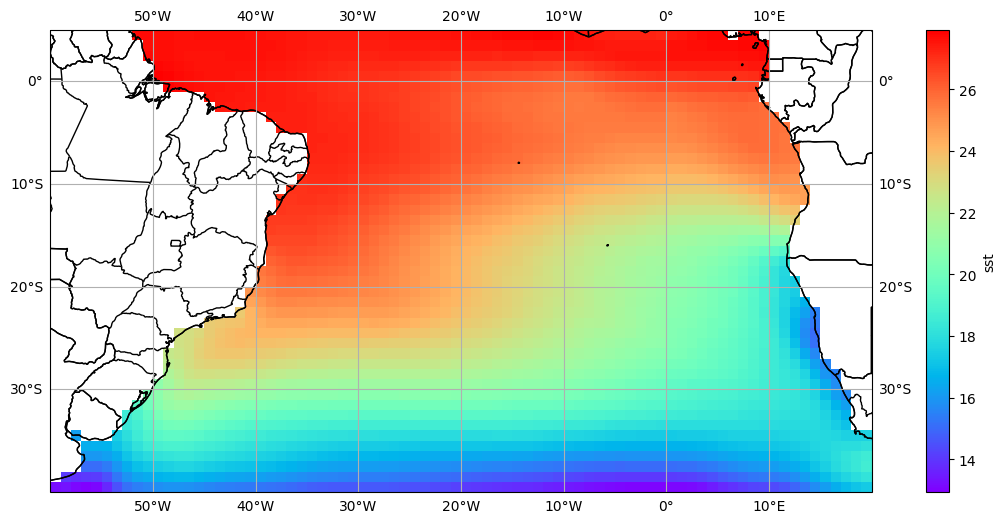

In [7]:
# Vamos fazer um simples mapa da região (bonito!!) com a média da SST
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# a seleção do que queremos plotar está aqui
dset_SA.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
         x='lon',y='lat',
         cmap='rainbow',add_colorbar=True) # você pode ainda controlar min e max de cores com vmin e vmax

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

paises = NaturalEarthFeature(category='cultural',scale='50m',facecolor='none',
                               name='admin_0_countries')
estados = NaturalEarthFeature(category='cultural',scale='50m',facecolor='none',
                               name='admin_1_states_provinces_lines')

ax.add_feature(paises,facecolor='none',edgecolor='black')
ax.add_feature(estados,facecolor='none',edgecolor='black')

ax.coastlines()

## Um pouco de teoria...

### varimax rotated PCA analysis
Para abordar algumas das limitações da análise EOF clássica, os pesquisadores "alternam" os EOFs clássicos. Alguns métodos rotacionais retêm a ortogonalidade dos modos, mas não os componentes principais ou vice-versa. Mais comumente, a rotação `varimax` tem sido usada (que é você procurar os espaços de variância máxima do universo de dados). O objetivo é minimizar a complexidade do modo empírico, tornando os grandes pesos maiores e os menores pesos obviamente menores (é como uma "distensão" da variância para ocupar todo o espaço da componente). Inicialmente, uma análise EOF padrão é realizada e um subconjunto EOF (por exemplo, 4 ou 5) é retido e submetido à rotação varimax. Alguns acham que os padrões resultantes são mais interpretáveis fisicamente. Ainda assim, os métodos REOF têm problemas. Os padrões ainda podem ser dependentes do domínio e o número inicial de EOFs retidos é arbitrário, ou seja, dependem da variância dos dados distribuida espacialmente.

** A interpretação deste resultado deve ser realizada com calma **. Não tente de cara arrumar uma explicação física. A EOF ajuda ainda separar áreas geográficas distintas.<br>

##unrotated EOFs analysis

Lembrando aqui que por construção, os padrões EOF e os componentes principais são independentes. Dois fatores inibem a interpretação física dos EOFs: (1) a restrição de ortogonalidade e (2) os padrões derivados podem ser dependentes do domínio. Os sistemas físicos não são necessariamente ortogonais e se os padrões dependerem da região usada, eles podem não existir se o domínio mudar. Ainda assim, mesmo com essas deficiências, a análise clássica EOF (PCA) provou ser útil. Normalmente fazemos uma `unrotated EOF` primeiro


# agora com o EOFS

O pacote `eofs` tem ferramentas similares, mas a maneira de processar os dados primários é um pouco diferente. Embora pareça muito mais simples e de aplicação direta, não fica muito claro como utilizar o pacote para explorar as diferentes variações da EOF (falta um pouco de explicação na própria documentação). Porém, isso não impede de se estudar o método e utilizar o pacote para aplicação da EOF com algum índice. O mais interessante é que não precisa transformar em dataframe para a análise. O resultado é direto.


In [19]:
# vamos começar instalando o eofs
!pip install eofs

In [9]:
# importa o que precisamos para ele
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof #<- a diferença está simplesmente aqui....só chamar outra biblioteca

In [10]:
# vamos definir aqui uma anomalia de temperatura
dset_anom = dset_SA - dset_SA.mean(dim='time')  #<---- note que não é um dataframe



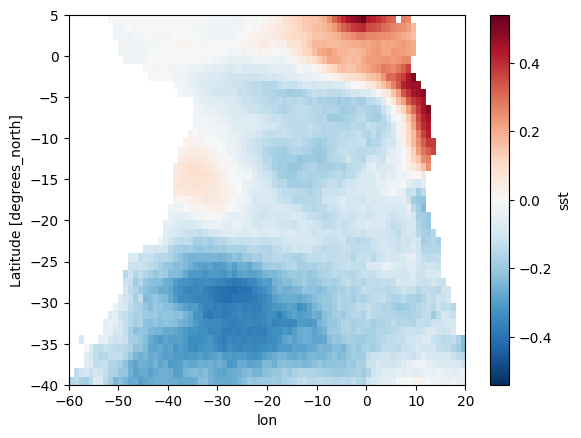

In [11]:
# Para os neuróricos... plota a mediana da anomalia de temperatura
dset_anom.median('time').plot()

In [12]:
# se eu realmente sou neurotico quero ver o dataset
dset_anom

<xarray.DataArray 'sst' (time: 1590, lat: 45, lon: 80)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  2.2274303 ,
          2.3261528 ,  2.3743    ],
        [        nan,  2.0279589 ,  1.921032  , ...,  1.8823185 ,
          1.9359379 ,  2.012064  ],
        [ 2.149518  ,  2.076066  ,  1.8869152 , ...,  1.5392838 ,
          1.5895061 ,  1.6859798 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,  1.4599304 ,
          1.353653  ,  1.6168003 ],
        [        nan,  1.5704594 ,  1.5210314 , ...,  1.7598171 ,
          1.4234371 ,  1.864563  ],
        [ 1.3870182 ,  1.4860659 ,  1.4794149 , ...,  1.8767853 ,
          1.5295067 ,  1.6109791 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., -0.52256966,
         -0.8863468 , -0.87319946],
        [        nan, -0.6870403 , -0.63896847, ..., -0.50518227,
         -0.7565632 , -0.65543556],
        [-0.5854826 , -0.4364338 , -0.41308498, ..., -0.25821495,
         -0.38799286, -0.40901947]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 4.5 3.5 2.5 1.5 0.5 ... -35.5 -36.5 -37.5 -38.5 -39.5
  * lon      (lon) float32 -59.5 -58.5 -57.5 -56.5 -55.5 ... 16.5 17.5 18.5 19.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2023-06-01

In [13]:
# a sequencia é criar um solver do dado e chamar as EOFs
solver = Eof(dset_anom)  #<-- note que é feito explicitamente com a variável que queremos, mesmo que o dset_anom só tenha 1 variável

In [14]:
# aqui usamos o solver para calcular a EOF e a correlação
n = 3

eofs_da = solver.eofsAsCorrelation(neofs=n) # basicamente as EOFs distribuidas como o array
pcs = solver.pcs(npcs=n) # são as PCs
evfs = solver.varianceFraction(neigs=n) #são as frações de variância na forma de xarray

In [15]:
eofs_da

<xarray.DataArray 'eofs' (mode: 3, lat: 45, lon: 80)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  0.90472126,
          0.90082574,  0.8987839 ],
        [        nan,  0.93415314,  0.93277186, ...,  0.89432245,
          0.8910255 ,  0.8905887 ],
        [ 0.93037426,  0.92976475,  0.9278778 , ...,  0.882794  ,
          0.88370544,  0.88587487]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,  0.20426022,
          0.21951646,  0.22765362],
        [        nan,  0.2598936 ,  0.2646415 , ...,  0.17271943,
          0.18792099,  0.19329655],
        [ 0.25963038,  0.26416737,  0.26875332, ...,  0.1305146 ,
          0.14375155,  0.15240398]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., -0.12540498,
         -0.13522944, -0.13646361],
        [        nan, -0.12304109, -0.12335786, ..., -0.12080839,
         -0.13239978, -0.1355772 ],
        [-0.1072896 , -0.10984956, -0.10974014, ..., -0.09869374,
         -0.10815257, -0.11184622]]], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
  * lat      (lat) float32 4.5 3.5 2.5 1.5 0.5 ... -35.5 -36.5 -37.5 -38.5 -39.5
  * lon      (lon) float32 -59.5 -58.5 -57.5 -56.5 -55.5 ... 16.5 17.5 18.5 19.5
Attributes:
    long_name:  correlation_between_pcs_and_sst

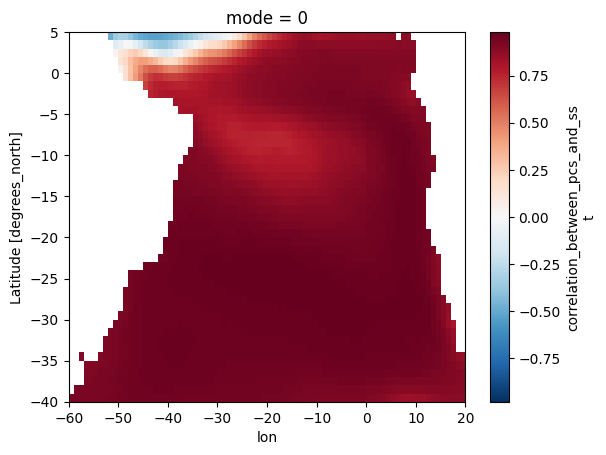

In [16]:
# apenas um teste
eofs_da.sel(mode=0).plot()

In [17]:
# Criamos uma subrotina para plotar por "conveniência" para nossa área de interesse

def visualization_EOFS(da, pcs, eofs_da, evfs, title):
    # da : dataset original
    # pcs: Componentes principais. Tem um shape N data x N componentes (em xarray)
    # eofs_da: As componentes distribuidas espacialmente em um xarray. Notem que o dado tem N componentes
    # evf: Variancia explicada de cada componente (em xarray)
    # title: título da sua figura

    fig = plt.figure(figsize = (10,15))

    ax = fig.add_subplot(n+1,2,1)
    da.mean(dim=["lat","lon"]).plot(ax=ax)
    ax.set_title(title) # mude aqui para o parâmetro que você deseja

    ax = fig.add_subplot(n+1,2,2)
    da.mean(dim="time").plot(ax=ax)
    ax.set_title(title)

    for i in range(1,n+1):
        pc_i = pcs[:,i-1]
        eof_i = eofs_da.sel(mode=i-1)
        frac = str(np.array(evfs[i-1]*100).round(2))

        ax = fig.add_subplot(n+1,2,i*2+1)
        pc_i.plot(ax=ax)
        ax.set_title("PC"+str(i)+" ("+frac+"%)")

        ax = fig.add_subplot(n+1,2,i*2+2)
        eof_i.plot(ax=ax,
                   vmin=-1, vmax=1, cmap="RdBu_r",
                   cbar_kwargs={'label': ""})
        ax.set_title("EOF"+str(i)+" ("+frac+"%)")

    plt.tight_layout()
    plt.show()

%matplotlib inline

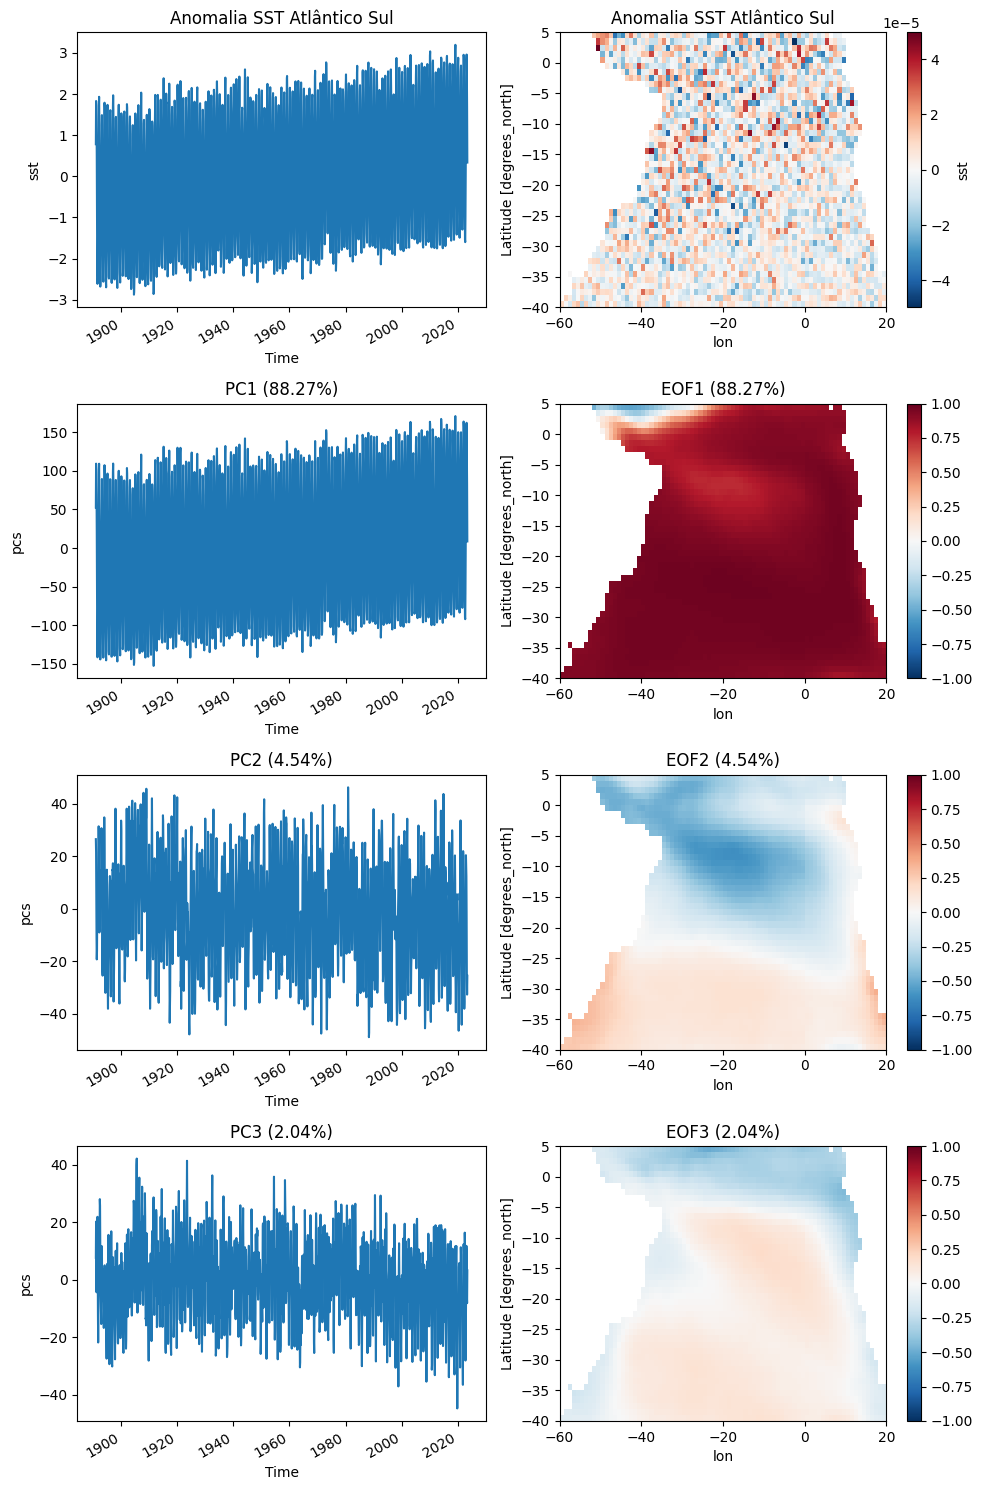

In [18]:
# vizualisando aqui...
visualization_EOFS(dset_anom, pcs, eofs_da, evfs, 'Anomalia SST Atlântico Sul')

Este resultado é o que chamamos de unrotated EOF.
1. Você consegue entender o significado dessa análise ?
2. Note que aqui, a ideia é usar a EOF para verificar diferenças espaciais sobre o eixo temporal (e por isso mesmo, estatisticamente representar a EOF como correlação é importante)
3. Mas o que acontece se você representar a EOF como covariancia ?
4. E se desazonalizar as séries antes de fazer isso ?
<br>
dois links interessantes de explorar tratam de desazonalização de séries
<br>
1.https://machinelearningmastery.com/time-series-seasonality-with-python/<br>
2.https://analyticsindiamag.com/comprehensive-guide-to-deseasonalizing-time-series/<br>

Faça experiências com essas receitas dentro de um mesmo notebook.
